In [1]:
from  datetime import datetime, timedelta
import gc
import numpy as np, pandas as pd
import lightgbm as lgb
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
from tqdm import tqdm

# Changes
* v5 : try to optimise the LGBM params (go below in lgbm params section to see changes)

In [3]:
# helper functions to reduce memory
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
CAL_DTYPES={"event_name_1": "category", "event_name_2": "category", "event_type_1": "category", 
         "event_type_2": "category", "weekday": "category", 'wm_yr_wk': 'int16', "wday": "int16",
        "month": "int16", "year": "int16", "snap_CA": "float32", 'snap_TX': 'float32', 'snap_WI': 'float32' }
PRICE_DTYPES = {"store_id": "category", "item_id": "category", "wm_yr_wk": "int16","sell_price":"float32" }

In [5]:
pd.options.display.max_columns = 50

In [6]:
h = 28 
max_lags = 57
tr_last = 1941
fday = datetime(2016,4, 25) 
fday

datetime.datetime(2016, 4, 25, 0, 0)

In [7]:
def create_dt(is_train = True, nrows = None, first_day = 1200):
    prices = pd.read_csv("sell_prices.csv", dtype = PRICE_DTYPES)
    for col, col_dtype in PRICE_DTYPES.items():
        if col_dtype == "category":
            prices[col] = prices[col].cat.codes.astype("int16")
            prices[col] -= prices[col].min()
            
    cal = pd.read_csv("calendar.csv", dtype = CAL_DTYPES)
    cal["date"] = pd.to_datetime(cal["date"])
    for col, col_dtype in CAL_DTYPES.items():
        if col_dtype == "category":
            cal[col] = cal[col].cat.codes.astype("int16")
            cal[col] -= cal[col].min()
    
    start_day = max(1 if is_train  else tr_last-max_lags, first_day)
    numcols = [f"d_{day}" for day in range(start_day,tr_last+1)]
    catcols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
    dtype = {numcol:"float32" for numcol in numcols} 
    dtype.update({col: "category" for col in catcols if col != "id"})
    ##########################################################################################
    #Remember to change this into 'sales_train_evaluation' before submitting the final prediction
    dt = pd.read_csv("sales_train_evaluation/sales_train_evaluation.csv", 
                     nrows = nrows, usecols = catcols + numcols, dtype = dtype)
    ############################################################################################
    
    for col in catcols:
        if col != "id":
            dt[col] = dt[col].cat.codes.astype("int16")
            dt[col] -= dt[col].min()
    
    if not is_train:
        for day in range(tr_last+1, tr_last+ 28 +1):
            dt[f"d_{day}"] = np.nan
    
    dt = pd.melt(dt,
                  id_vars = catcols,
                  value_vars = [col for col in dt.columns if col.startswith("d_")],
                  var_name = "d",
                  value_name = "sales")
    
    dt = dt.merge(cal, on= "d", copy = False)
    dt = dt.merge(prices, on = ["store_id", "item_id", "wm_yr_wk"], copy = False)
    
    return dt

In [8]:
def create_fea(dt):
    lags = [7, 28]
    lag_cols = [f"lag_{lag}" for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        dt[lag_col] = dt[["id","sales"]].groupby("id")["sales"].shift(lag)

    #Windows
    wins = [7, 28]
    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            dt[f"rmean_{lag}_{win}"] = dt[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean())

    
    
    date_features = {
        
        "wday": "weekday",
        "week": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",
#         "ime": "is_month_end",
#         "ims": "is_month_start",
    }
    
#     dt.drop(["d", "wm_yr_wk", "weekday"], axis=1, inplace = True)
    
    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in dt.columns:
            dt[date_feat_name] = dt[date_feat_name].astype("int16")
        else:
            dt[date_feat_name] = getattr(dt["date"].dt, date_feat_func).astype("int16")

In [8]:
########################################################Second try with another FE method
##########################################################################################
lags_roll = pd.read_pickle('lags_df_28.pkl')
lags_roll = reduce_mem_usage(lags_roll)
lags_roll.head()

Mem. usage decreased to 3577.02 Mb (7.0% reduction)


,id,d,sales,sales_lag_28,sales_lag_29,sales_lag_30,sales_lag_31,sales_lag_32,sales_lag_33,sales_lag_34,sales_lag_35,sales_lag_36,sales_lag_37,sales_lag_38,sales_lag_39,sales_lag_40,sales_lag_41,sales_lag_42,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,rolling_mean_30,rolling_std_30,rolling_mean_60,rolling_std_60,rolling_mean_180,rolling_std_180,rolling_mean_tmp_1_7,rolling_mean_tmp_1_14,rolling_mean_tmp_1_30,rolling_mean_tmp_1_60,rolling_mean_tmp_7_7,rolling_mean_tmp_7_14,rolling_mean_tmp_7_30,rolling_mean_tmp_7_60,rolling_mean_tmp_14_7,rolling_mean_tmp_14_14,rolling_mean_tmp_14_30,rolling_mean_tmp_14_60
0,HOBBIES_1_008_CA_1_validation,1,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HOBBIES_1_009_CA_1_validation,1,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HOBBIES_1_010_CA_1_validation,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HOBBIES_1_012_CA_1_validation,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HOBBIES_1_015_CA_1_validation,1,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
useless_rolling_lag_fea = [f'rolling_mean_tmp_{i}_{j}' for j in [7,14,30,60] for i in [1,7,14]]
lags_roll.drop(useless_rolling_lag_fea, axis=1,inplace=True)
lags_roll.tail()

,id,d,sales,sales_lag_28,sales_lag_29,sales_lag_30,sales_lag_31,sales_lag_32,sales_lag_33,sales_lag_34,sales_lag_35,sales_lag_36,sales_lag_37,sales_lag_38,sales_lag_39,sales_lag_40,sales_lag_41,sales_lag_42,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,rolling_mean_30,rolling_std_30,rolling_mean_60,rolling_std_60,rolling_mean_180,rolling_std_180
46881672,FOODS_3_823_WI_3_validation,1941,NaN,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.285645,0.488037,0.428467,7.558594e-01,0.199951,0.550781,0.250000,0.571289,0.616699,0.987305
46881673,FOODS_3_824_WI_3_validation,1941,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.142822,0.377930,0.214233,4.257812e-01,0.300049,0.535156,0.150024,0.404541,0.049988,0.242798
46881674,FOODS_3_825_WI_3_validation,1941,NaN,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,2.0,0.0,0.0,0.0,4.0,2.0,0.571289,0.786621,0.785645,1.188477e+00,0.866699,1.136719,1.033203,1.056641,0.761230,0.941895
46881675,FOODS_3_826_WI_3_validation,1941,NaN,3.0,1.0,3.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,1.0,0.0,2.0,1.142578,1.344727,0.928711,1.207031e+00,1.066406,1.172852,1.016602,1.065430,1.338867,1.550781
46881676,FOODS_3_827_WI_3_validation,1941,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.192093e-07,1.166992,1.821289,1.500000,1.770508,1.510742,1.741211


In [10]:
pred_set = lags_roll[lags_roll['d']>1913]
pred_set.shape

(853720, 28)

In [10]:
FIRST_DAY = 350 # If you want to load all the data set it to '1' -->  Great  memory overflow  risk !

In [12]:
train_set = lags_roll[(lags_roll['d'] >= FIRST_DAY) & (lags_roll['d'] <= 1913)]
train_set.shape

(40718219, 28)

In [13]:
train_set.dropna(inplace=True)
train_set.shape

(37743321, 28)

In [14]:
del lags_roll;gc.collect()

120

In [11]:
%%time

df = create_dt(is_train=True, first_day= FIRST_DAY)
df.shape

Wall time: 35.4 s


(41571939, 22)

In [12]:
df['d'] = df['d'].str.slice(2)
df['d'] = df['d'].astype('int16')
df = reduce_mem_usage(df)

Mem. usage decreased to 2101.24 Mb (28.4% reduction)


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41571939 entries, 0 to 41571938
Data columns (total 22 columns):
id              object
item_id         int16
dept_id         int8
store_id        int8
cat_id          int8
state_id        int8
d               int16
sales           float16
date            datetime64[ns]
wm_yr_wk        int16
weekday         int8
wday            int8
month           int8
year            int16
event_name_1    int8
event_type_1    int8
event_name_2    int8
event_type_2    int8
snap_CA         float16
snap_TX         float16
snap_WI         float16
sell_price      float16
dtypes: datetime64[ns](1), float16(5), int16(4), int8(11), object(1)
memory usage: 2.1+ GB


In [14]:
%%time

create_fea(df)
df.shape

Wall time: 3min 24s


(41571939, 31)

In [15]:
df.head()

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_7,lag_28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,week,quarter,mday
0,HOBBIES_1_002_CA_1_evaluation,1,0,0,0,0,350,0.0,2012-01-13,11150,0,7,1,2012,0,0,0,0,0.0,1.0,0.0,3.970703,NaN,NaN,NaN,NaN,NaN,NaN,2,1,13
1,HOBBIES_1_004_CA_1_evaluation,3,0,0,0,0,350,2.0,2012-01-13,11150,0,7,1,2012,0,0,0,0,0.0,1.0,0.0,4.339844,NaN,NaN,NaN,NaN,NaN,NaN,2,1,13
2,HOBBIES_1_005_CA_1_evaluation,4,0,0,0,0,350,0.0,2012-01-13,11150,0,7,1,2012,0,0,0,0,0.0,1.0,0.0,2.480469,NaN,NaN,NaN,NaN,NaN,NaN,2,1,13
3,HOBBIES_1_008_CA_1_evaluation,7,0,0,0,0,350,0.0,2012-01-13,11150,0,7,1,2012,0,0,0,0,0.0,1.0,0.0,0.500000,NaN,NaN,NaN,NaN,NaN,NaN,2,1,13
4,HOBBIES_1_009_CA_1_evaluation,8,0,0,0,0,350,2.0,2012-01-13,11150,0,7,1,2012,0,0,0,0,0.0,1.0,0.0,1.769531,NaN,NaN,NaN,NaN,NaN,NaN,2,1,13


In [18]:
%%time

train_combined = df.merge(train_set,left_on=['id','d'],right_on=['id','d'])

Wall time: 50.1 s


In [19]:
train_combined = reduce_mem_usage(train_combined)
train_combined.info()

Mem. usage decreased to 3667.67 Mb (0.0% reduction)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 36626960 entries, 0 to 36626959
Data columns (total 48 columns):
id                  object
item_id             int16
dept_id             int8
store_id            int8
cat_id              int8
state_id            int8
d                   int16
sales_x             float16
date                datetime64[ns]
wm_yr_wk            int16
weekday             int8
wday                int8
month               int8
year                int16
event_name_1        int8
event_type_1        int8
event_name_2        int8
event_type_2        int8
snap_CA             float16
snap_TX             float16
snap_WI             float16
sell_price          float16
sales_y             float16
sales_lag_28        float16
sales_lag_29        float16
sales_lag_30        float16
sales_lag_31        float16
sales_lag_32        float16
sales_lag_33        float16
sales_lag_34        float16
sales_lag_35        float16


In [20]:
train_combined['sales'] = train_combined['sales_x']
train_combined.drop(['sales_y','sales_x'],axis=1,inplace=True)

In [21]:
del df,train_set; gc.collect()

40

In [22]:
%%time

# create_fea(df)
# df.shape

create_fea(train_combined)
train_combined.shape

Wall time: 9.57 s


(36626960, 50)

In [23]:
train_combined.head()

,id,item_id,dept_id,store_id,cat_id,state_id,d,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,sales_lag_28,sales_lag_29,sales_lag_30,sales_lag_31,sales_lag_32,sales_lag_33,sales_lag_34,sales_lag_35,sales_lag_36,sales_lag_37,sales_lag_38,sales_lag_39,sales_lag_40,sales_lag_41,sales_lag_42,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,rolling_mean_30,rolling_std_30,rolling_mean_60,rolling_std_60,rolling_mean_180,rolling_std_180,sales,week,quarter,mday
0,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,350,2012-01-13,11150,0,7,1,2012,0,0,0,0,0.0,1.0,0.0,3.970703,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.571289,0.976074,0.428467,0.755859,0.233276,0.568359,0.250000,0.508301,0.244385,0.456055,0.0,2,1,13
1,HOBBIES_1_004_CA_1_validation,3,0,0,0,0,350,2012-01-13,11150,0,7,1,2012,0,0,0,0,0.0,1.0,0.0,4.339844,2.0,2.0,3.0,1.0,3.0,6.0,1.0,1.0,2.0,0.0,2.0,3.0,2.0,4.0,0.0,2.572266,1.717773,2.285156,1.490234,1.766602,1.455078,1.700195,1.393555,1.744141,1.532227,2.0,2,1,13
2,HOBBIES_1_005_CA_1_validation,4,0,0,0,0,350,2012-01-13,11150,0,7,1,2012,0,0,0,0,0.0,1.0,0.0,2.480469,0.0,0.0,6.0,3.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,2.000000,2.160156,1.286133,1.772461,1.066406,1.436523,1.066406,1.299805,1.094727,1.709961,0.0,2,1,13
3,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,350,2012-01-13,11150,0,7,1,2012,0,0,0,0,0.0,1.0,0.0,0.500000,1.0,16.0,0.0,10.0,4.0,1.0,1.0,23.0,0.0,48.0,2.0,0.0,6.0,16.0,21.0,4.714844,6.046875,9.140625,13.398438,9.664062,11.234375,9.320312,10.906250,8.187500,8.984375,0.0,2,1,13
4,HOBBIES_1_009_CA_1_validation,8,0,0,0,0,350,2012-01-13,11150,0,7,1,2012,0,0,0,0,0.0,1.0,0.0,1.769531,3.0,1.0,2.0,5.0,0.0,5.0,3.0,1.0,0.0,0.0,2.0,0.0,6.0,1.0,0.0,2.714844,1.889648,2.072266,2.054688,1.933594,2.273438,1.700195,2.226562,1.644531,2.378906,2.0,2,1,13


In [16]:
df.dropna(inplace = True)
df.shape

(39894989, 31)

## Branch 1

*Normal training step*

In [17]:
cat_feats = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id'] + ["event_name_1", "event_name_2", "event_type_1", "event_type_2"]
useless_cols = ["id", "date", "sales","d", "wm_yr_wk", "weekday"]
train_cols = df.columns[~df.columns.isin(useless_cols)]
X_train = df[train_cols]
y_train = df["sales"]

In [18]:
# train_data = lgb.Dataset(X_train, label = y_train, categorical_feature=cat_feats, free_raw_data=False)
# fake_valid_inds = np.random.choice(len(X_train), 1000000, replace = False)
# fake_valid_data = lgb.Dataset(X_train.iloc[fake_valid_inds], label = y_train.iloc[fake_valid_inds],categorical_feature=cat_feats,
#                              free_raw_data=False)   # This is just a subsample of the training set, not a real validation set !

In [20]:
%%time

np.random.seed(777)

fake_valid_inds = np.random.choice(X_train.index.values, 2_000_000, replace = False)
train_inds = np.setdiff1d(X_train.index.values, fake_valid_inds)
train_data = lgb.Dataset(X_train.loc[train_inds] , label = y_train.loc[train_inds], 
                         categorical_feature=cat_feats, free_raw_data=False)
fake_valid_data = lgb.Dataset(X_train.loc[fake_valid_inds], label = y_train.loc[fake_valid_inds],
                              categorical_feature=cat_feats,
                 free_raw_data=False)# This is a random sample, we're not gonna apply any time series train-test-split tricks here!

Wall time: 20.6 s


In [21]:
del X_train, y_train, fake_valid_inds,train_inds ; gc.collect()

40

In [22]:
params_1 = {
        "objective" : "poisson",
        "metric" :"rmse",
        "force_row_wise" : True,
        "learning_rate" : 0.075,
#         "sub_feature" : 0.8,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        "lambda_l2" : 0.1,
#         "nthread" : 4
        "metric": ["rmse"],
        'verbosity': 1,
        'num_iterations' : 1200,
        'num_leaves': 128,
        "min_data_in_leaf": 100,
}

params_2 = {
        'boosting_type': 'gbdt',
        'objective': 'tweedie',
        'tweedie_variance_power': 1.1,
        "metric" :"rmse",
        "force_row_wise" : True,
        "learning_rate" : 0.075,
#         "sub_feature" : 0.8,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        "lambda_l2" : 0.1,
#         "nthread" : 4
        "metric": ["rmse"],
        'verbosity': 1,
        'num_iterations' : 1200,
        'num_leaves': 128,
        "min_data_in_leaf": 100,
}



params_3 = {
            'boosting_type': 'gbdt',
            'objective': 'tweedie',
            'tweedie_variance_power': 1.1,
            'metric': 'rmse',
            'subsample': 0.5,
            'subsample_freq': 1,
            'learning_rate': 0.03,
            'num_leaves': 2**11-1,
            'min_data_in_leaf': 2**12-1,
            'feature_fraction': 0.5,
            'max_bin': 100,
            'n_estimators': 1400,
            'boost_from_average': False,
            'verbose': 1,
}

In [ ]:
%%time

m_lgb = lgb.train(params_3, train_data, valid_sets = [fake_valid_data], verbose_eval=20) 

[20]	valid_0's rmse: 3.41542
[40]	valid_0's rmse: 2.86641
[60]	valid_0's rmse: 2.63785
[80]	valid_0's rmse: 2.55269
[100]	valid_0's rmse: 2.51874
[120]	valid_0's rmse: 2.50157
[140]	valid_0's rmse: 2.48969
[160]	valid_0's rmse: 2.47924
[180]	valid_0's rmse: 2.47114
[200]	valid_0's rmse: 2.46391
[220]	valid_0's rmse: 2.45679
[240]	valid_0's rmse: 2.45182
[260]	valid_0's rmse: 2.44673
[280]	valid_0's rmse: 2.44257
[300]	valid_0's rmse: 2.43827
[320]	valid_0's rmse: 2.43502
[340]	valid_0's rmse: 2.43052
[360]	valid_0's rmse: 2.42774
[380]	valid_0's rmse: 2.4239
[400]	valid_0's rmse: 2.42145
[420]	valid_0's rmse: 2.41909
[440]	valid_0's rmse: 2.4167
[460]	valid_0's rmse: 2.41473
[480]	valid_0's rmse: 2.41193
[500]	valid_0's rmse: 2.40974
[520]	valid_0's rmse: 2.40759
[540]	valid_0's rmse: 2.40591


In [64]:
m_lgb.save_model("model_private_lb_param2_eval.lgb")

In [32]:
tt = create_dt(False)
tt_pred = tt[tt['date'] >= fday]

tt_pred['d'] = tt_pred['d'].str.slice(2)
tt_pred['d'] = tt_pred['d'].astype('int16')
tt_pred = reduce_mem_usage(tt_pred)

In [57]:
pred_combined = tt_pred.merge(pred_set,left_on=['id','d'],right_on=['id','d'])
pred_combined.head()

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales_x,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,sales_y,sales_lag_28,sales_lag_29,sales_lag_30,sales_lag_31,sales_lag_32,sales_lag_33,sales_lag_34,sales_lag_35,sales_lag_36,sales_lag_37,sales_lag_38,sales_lag_39,sales_lag_40,sales_lag_41,sales_lag_42,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,rolling_mean_30,rolling_std_30,rolling_mean_60,rolling_std_60,rolling_mean_180,rolling_std_180
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,1914,NaN,2016-04-25,11613,1,3,4,2016,0,0,0,0,0.0,0.0,0.0,8.382812,NaN,1.0,1.0,1.0,1.0,0.0,2.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,1.0,0.0,1.142578,0.689941,1.357422,0.841797,1.033203,0.927734,0.983398,1.081055,0.772461,0.996094
1,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,1915,NaN,2016-04-26,11613,5,4,4,2016,0,0,0,0,0.0,0.0,0.0,8.382812,NaN,0.0,1.0,1.0,1.0,1.0,0.0,2.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,1.0,0.856934,0.689941,1.286133,0.914062,0.966797,0.927734,0.983398,1.081055,0.766602,0.997559
2,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,1916,NaN,2016-04-27,11613,6,5,4,2016,0,0,0,0,0.0,0.0,0.0,8.382812,NaN,0.0,0.0,1.0,1.0,1.0,1.0,0.0,2.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,0.571289,0.534668,1.213867,0.975098,0.966797,0.927734,0.983398,1.081055,0.761230,0.999023
3,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,1917,NaN,2016-04-28,11613,4,6,4,2016,0,0,0,0,0.0,0.0,0.0,8.382812,NaN,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,2.0,2.0,1.0,3.0,1.0,3.0,1.0,0.571289,0.534668,1.142578,1.027344,0.899902,0.922852,0.966797,1.088867,0.761230,0.999023
4,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,1918,NaN,2016-04-29,11613,0,7,4,2016,0,0,0,0,0.0,0.0,0.0,8.382812,NaN,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,2.0,2.0,1.0,3.0,1.0,3.0,0.428467,0.534668,0.928711,0.916992,0.899902,0.922852,0.950195,1.095703,0.755371,1.000977


In [60]:
pred_combined.shape

(853720, 48)

In [24]:
%%time

alphas = [1.018, 1, 0.955]
weights = [1/len(alphas)]*len(alphas)
sub = 0.

#The reason why we iterate over the follow codes three times is because in each iteration we use a different alphas value.
for icount, (alpha, weight) in enumerate(zip(alphas, weights)):

    te = create_dt(False)
    cols = [f"F{i}" for i in range(1,29)]
    
#     te = create_dt(False)
#     tt_pred = te[te['date'] >= fday]

#     tt_pred['d'] = tt_pred['d'].str.slice(2)
#     tt_pred['d'] = tt_pred['d'].astype('int16')
#     tt_pred = reduce_mem_usage(tt_pred)
    
    #Combined dataset that has all features needed 
#     pred_combined = tt_pred.merge(pred_set,left_on=['id','d'],right_on=['id','d'])
#     pred_combined['sales'] = pred_combined['sales_x']
#     pred_combined.drop(['sales_y','sales_x'],axis=1,inplace=True)

    #So technically, we can comment out some code in this block if we already have the features in hand
    for tdelta in range(0, 28):
        #Iterate over the next 28 days in datetime format
        day = fday + timedelta(days=tdelta)
        #Verbose
        print(tdelta, day)
        #This df limits date from last 57 days
        tst = te[(te.date >= day - timedelta(days=max_lags)) & (te.date <= day)].copy()
        #######################################################################################
        #To further explain, we need the tst dataframe in the previous line so that we could generate 
        #lags and rolling features for prediction data based on them
        create_fea(tst)
        #############################################################################
        #Now loc tst to focus on the current data entry
        tst = tst.loc[tst.date == day , train_cols]
#         tst = pred_combined.loc[pred_combined.date == day, train_cols]
        #######################################################################
        #Make prediction of the current data entry using trained lgbm model
        te.loc[te.date == day, "sales"] = alpha*m_lgb.predict(tst) # magic multiplier
#         pred_combined.loc[pred_combined.date == day, "sales"] = alpha*m_lgb.predict(tst) # magic multiplier by kyakovlev




#     te_sub = pred_combined.loc[pred_combined.date >= fday, ["id", "sales"]].copy()
    te_sub.loc[te.date >= fday+ timedelta(days=h), "id"] = te_sub.loc[te.date >= fday+timedelta(days=h), 
                                                                          "id"].str.replace("validation$", "evaluation")
    te_sub["F"] = [f"F{rank}" for rank in te_sub.groupby("id")["id"].cumcount()+1]
    te_sub = te_sub.set_index(["id", "F" ]).unstack()["sales"][cols].reset_index()
    te_sub.fillna(0., inplace = True)
    te_sub.sort_values("id", inplace = True)
    te_sub.reset_index(drop=True, inplace = True)
    te_sub.to_csv(f"submission_{icount}.csv",index=False)
    if icount == 0 :
        sub = te_sub
        sub[cols] *= weight
    else:
        sub[cols] += te_sub[cols]*weight
    print(icount, alpha, weight)


#Create evaluation set
sub2 = sub.copy()
sub2["id"] = sub2["id"].str.replace("validation$", "evaluation")
sub = pd.concat([sub, sub2], axis=0, sort=False)
sub.to_csv("submission_alpha_around_1.csv",index=False)

0 2016-04-25 00:00:00
1 2016-04-26 00:00:00
2 2016-04-27 00:00:00
3 2016-04-28 00:00:00
4 2016-04-29 00:00:00
5 2016-04-30 00:00:00
6 2016-05-01 00:00:00
7 2016-05-02 00:00:00
8 2016-05-03 00:00:00
9 2016-05-04 00:00:00
10 2016-05-05 00:00:00
11 2016-05-06 00:00:00
12 2016-05-07 00:00:00
13 2016-05-08 00:00:00
14 2016-05-09 00:00:00
15 2016-05-10 00:00:00
16 2016-05-11 00:00:00
17 2016-05-12 00:00:00
18 2016-05-13 00:00:00
19 2016-05-14 00:00:00
20 2016-05-15 00:00:00
21 2016-05-16 00:00:00
22 2016-05-17 00:00:00
23 2016-05-18 00:00:00
24 2016-05-19 00:00:00
25 2016-05-20 00:00:00
26 2016-05-21 00:00:00
27 2016-05-22 00:00:00


NameError: name 'te_sub' is not defined

In [65]:
alphas = [1.028, 1.023, 1.018]
weights = [1/len(alphas)]*len(alphas)
sub = 0.
fday = datetime(2016,5,23)

for icount, (alpha, weight) in enumerate(zip(alphas, weights)):

    te = create_dt(False)
    cols = [f"F{i}" for i in range(1,29)]

    for tdelta in range(0, 28):
        day = fday + timedelta(days=tdelta)
        print(tdelta, day)
        tst = te[(te.date >= day - timedelta(days=max_lags)) & (te.date <= day)].copy()
        create_fea(tst)
        tst = tst.loc[tst.date == day , train_cols]
        te.loc[te.date == day, "sales"] = alpha*m_lgb.predict(tst) # magic multiplier



    te_sub = te.loc[te.date >= fday, ["id", "sales"]].copy()
#     te_sub.loc[te.date >= fday+ timedelta(days=h), "id"] = te_sub.loc[te.date >= fday+timedelta(days=h), 
#                                                                           "id"].str.replace("validation$", "evaluation")
    te_sub["F"] = [f"F{rank}" for rank in te_sub.groupby("id")["id"].cumcount()+1]
    te_sub = te_sub.set_index(["id", "F" ]).unstack()["sales"][cols].reset_index()
    te_sub.fillna(0., inplace = True)
    te_sub.sort_values("id", inplace = True)
    te_sub.reset_index(drop=True, inplace = True)
    te_sub.to_csv(f"submission_{icount}.csv",index=False)
    if icount == 0 :
        sub = te_sub
        sub[cols] *= weight
    else:
        sub[cols] += te_sub[cols]*weight
    print(icount, alpha, weight)

    

#Create evaluation set
sub2 = sub.copy()
sub2["id"] = sub2["id"].str.replace("validation$", "evaluation")
sub = pd.concat([sub, sub2], axis=0, sort=False)
sub.to_csv("submission_subformal_forecast_param2_evaluation.csv",index=False)

0 2016-05-23 00:00:00
1 2016-05-24 00:00:00
2 2016-05-25 00:00:00
3 2016-05-26 00:00:00
4 2016-05-27 00:00:00
5 2016-05-28 00:00:00
6 2016-05-29 00:00:00
7 2016-05-30 00:00:00
8 2016-05-31 00:00:00
9 2016-06-01 00:00:00
10 2016-06-02 00:00:00
11 2016-06-03 00:00:00
12 2016-06-04 00:00:00
13 2016-06-05 00:00:00
14 2016-06-06 00:00:00
15 2016-06-07 00:00:00
16 2016-06-08 00:00:00
17 2016-06-09 00:00:00
18 2016-06-10 00:00:00
19 2016-06-11 00:00:00
20 2016-06-12 00:00:00
21 2016-06-13 00:00:00
22 2016-06-14 00:00:00
23 2016-06-15 00:00:00
24 2016-06-16 00:00:00
25 2016-06-17 00:00:00
26 2016-06-18 00:00:00
27 2016-06-19 00:00:00
0 1.028 0.3333333333333333
0 2016-05-23 00:00:00
1 2016-05-24 00:00:00
2 2016-05-25 00:00:00
3 2016-05-26 00:00:00
4 2016-05-27 00:00:00
5 2016-05-28 00:00:00
6 2016-05-29 00:00:00
7 2016-05-30 00:00:00
8 2016-05-31 00:00:00
9 2016-06-01 00:00:00
10 2016-06-02 00:00:00
11 2016-06-03 00:00:00
12 2016-06-04 00:00:00
13 2016-06-05 00:00:00
14 2016-06-06 00:00:00
15 2

In [73]:
sub.id.nunique(), sub["id"].str.contains("validation$").sum()

(60980, 30490)

In [74]:
sub.shape

(60980, 29)

In [47]:
df.tail()

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_7,lag_28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,week,quarter,mday
40718214,FOODS_3_825_WI_3_evaluation,3046,6,9,2,2,1913,0.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,3.980469,0.0,1.0,1.000000,0.714355,0.928711,1.250000,16,2,24
40718215,FOODS_3_826_WI_3_evaluation,3047,6,9,2,2,1912,1.0,2016-04-23,11613,2,1,4,2016,0,0,0,0,0.0,0.0,0.0,1.280273,0.0,2.0,0.856934,1.142578,1.036133,1.107422,16,2,23
40718216,FOODS_3_826_WI_3_evaluation,3047,6,9,2,2,1913,3.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,1.280273,1.0,4.0,0.714355,1.571289,1.036133,1.250000,16,2,24
40718217,FOODS_3_827_WI_3_evaluation,3048,6,9,2,2,1912,0.0,2016-04-23,11613,2,1,4,2016,0,0,0,0,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000,2.285156,1.821289,1.786133,16,2,23
40718218,FOODS_3_827_WI_3_evaluation,3048,6,9,2,2,1913,0.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,1.000000,0.0,5.0,0.000000,2.427734,1.678711,1.963867,16,2,24


## Branch 2:

*Ensemble(Stacking) step*

In [21]:
model2 = lgb.Booster(model_file='models/model_with_param2.lgb')
model3 = lgb.Booster(model_file='models/model_with_param3.lgb')
# model4 = lgb.Booster(model_file='model_6_7_14_28_fe.lgb')

In [22]:
cat_feats = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id'] + ["event_name_1", "event_name_2", "event_type_1", "event_type_2"]
useless_cols = ["id", "date", "sales","d", "wm_yr_wk", "weekday"]
train_cols = df.columns[~df.columns.isin(useless_cols)]
X_train = df[train_cols]
y_train = df["sales"]

In [23]:
k = 5

df_train_index = [ind for ind in df.index]
fold_size = round(len(df_train_index)/k)

prediction_df = pd.DataFrame()

In [36]:
#5-fold validation loop
used_ind = []
valid_tracking = []
for i in range(5):
    #This step is to avoid duplicate validation set
    used_indices = pd.Series(used_ind)
    total = pd.Series(df_train_index)
    valid_cand = total[~total.isin(used_indices)].to_list()
    ###############################################################################
    #First argument is all candidates of unselected index
    #Second argument is the size of each fold
    #Third argument is set False to ensure no element is reused
    if i == 4:
        fold_size = fold_size - 1
    print('Making validation set......')
    validation_fold_index = np.random.choice(valid_cand,fold_size,replace=False)
    training_folds_index = np.setdiff1d(df_train_index,validation_fold_index)
    #Add used index into this list
    used_ind = used_ind + validation_fold_index.tolist()
    #Tracking the index of validation set used in this fold for further prediction step
    valid_tracking.append(validation_fold_index)
    print('Done!')
    ###################################################################################
    print('Making lightgbm data set......')
    lgb_train_data = lgb.Dataset(X_train.loc[training_folds_index] , label = y_train.loc[training_folds_index], 
                             categorical_feature=cat_feats, free_raw_data=False)
    lgb_valid_data = lgb.Dataset(X_train.loc[validation_fold_index], label = y_train.loc[validation_fold_index],
                                  categorical_feature=cat_feats,
                     free_raw_data=False)# This is a random sample, we're not gonna apply any time series train-test-split tricks here!
    print('Done!')
    ######################################### MEMORY WORK ##########################################################
    print('Clearing up space for training...')
    del validation_fold_index,training_folds_index ; gc.collect()
    
    print(f'Training model in fold {i}....')
    #We use model 2 as base model and later on model 3 as meta model
    m_lgb = lgb.train(params_2, lgb_train_data, valid_sets = [lgb_valid_data], verbose_eval=20)
    print('Done!')
    print('Saving model...')
    m_lgb.save_model(f'model_ensemble_fold{i}.lgb')
    print('Done!')
    del m_lgb; gc.collect()
    

Making validation set......
Done!
Making lightgbm data set......
Done!
Clearing up space for training...
Training model in fold 0....
[20]	valid_0's rmse: 2.57805
[40]	valid_0's rmse: 2.40189
[60]	valid_0's rmse: 2.37342
[80]	valid_0's rmse: 2.35777
[100]	valid_0's rmse: 2.34586
[120]	valid_0's rmse: 2.33623
[140]	valid_0's rmse: 2.32884
[160]	valid_0's rmse: 2.32074
[180]	valid_0's rmse: 2.31706
[200]	valid_0's rmse: 2.30879
[220]	valid_0's rmse: 2.30333
[240]	valid_0's rmse: 2.29958
[260]	valid_0's rmse: 2.29416
[280]	valid_0's rmse: 2.2887
[300]	valid_0's rmse: 2.28488
[320]	valid_0's rmse: 2.28234
[340]	valid_0's rmse: 2.27814
[360]	valid_0's rmse: 2.27686
[380]	valid_0's rmse: 2.27371
[400]	valid_0's rmse: 2.27042
[420]	valid_0's rmse: 2.26816
[440]	valid_0's rmse: 2.26476
[460]	valid_0's rmse: 2.26314
[480]	valid_0's rmse: 2.26211
[500]	valid_0's rmse: 2.2602
[520]	valid_0's rmse: 2.25852
[540]	valid_0's rmse: 2.2567
[560]	valid_0's rmse: 2.25452
[580]	valid_0's rmse: 2.25275
[60

[180]	valid_0's rmse: 2.34194
[200]	valid_0's rmse: 2.33482
[220]	valid_0's rmse: 2.33094
[240]	valid_0's rmse: 2.32692
[260]	valid_0's rmse: 2.32284
[280]	valid_0's rmse: 2.32002
[300]	valid_0's rmse: 2.31559
[320]	valid_0's rmse: 2.31177
[340]	valid_0's rmse: 2.30686
[360]	valid_0's rmse: 2.30403
[380]	valid_0's rmse: 2.30216
[400]	valid_0's rmse: 2.29926
[420]	valid_0's rmse: 2.29694
[440]	valid_0's rmse: 2.2939
[460]	valid_0's rmse: 2.2918
[480]	valid_0's rmse: 2.28998
[500]	valid_0's rmse: 2.28738
[520]	valid_0's rmse: 2.28489
[540]	valid_0's rmse: 2.28085
[560]	valid_0's rmse: 2.27894
[580]	valid_0's rmse: 2.2772
[600]	valid_0's rmse: 2.27626
[620]	valid_0's rmse: 2.2752
[640]	valid_0's rmse: 2.27413
[660]	valid_0's rmse: 2.27256
[680]	valid_0's rmse: 2.27182
[700]	valid_0's rmse: 2.27076
[720]	valid_0's rmse: 2.27003
[740]	valid_0's rmse: 2.26886
[760]	valid_0's rmse: 2.26728
[780]	valid_0's rmse: 2.26663
[800]	valid_0's rmse: 2.26599
[820]	valid_0's rmse: 2.26529
[840]	valid_0'

In [23]:
#Validation df for further prediction
validation_df = df.loc[validation_fold_index]
for i in range(5):
    print(f'Making predictions on validation fold{i}.....')
    for val_index in validation_fold_index:
        validation_df.loc[val_index,'sales'] = m_lgb.predict(X_train.loc[val_index,train_cols])
    ######################################### MEMORY WORK ##########################################################
    validation_df = reduce_mem_usage(validation_df)

    pd.concat(prediction_df,validation_df, ignore_index=True)
    print('Done!')
    ######################################### MEMORY WORK ##########################################################
    del validation_df, m_lgb;gc.collect()

7808254

In [80]:
prediction_df = pd.DataFrame()
for i in range(5):
    print(f'Round {i}')
    #Current model
    m_lgb = lgb.Booster(model_file=f'model_ensemble_fold{i}.lgb')
    #Validation set
    valid_set = valid_tracking[i]
    validation_df = df.loc[valid_set]
    for val_index in tqdm(range(len(valid_set))):
        tmp = df.loc[df.index==valid_set[val_index], train_cols]
        validation_df.loc[valid_set[val_index],'sales'] = m_lgb.predict(tmp)
    prediction_df = pd.concat([prediction_df,validation_df],ignore_index=True)
    del validation_df; gc.collect()

Round 0


  0%|                                                                       | 1844/7808254 [03:39<257:55:40,  8.41it/s]


KeyboardInterrupt: 

In [113]:
LASTDAY_OF_TEST_SET = 1941
LASTDAY_OF_TRAINING_SET = 1913
NUM_OF_ENTRY_PER_DAY = 30490

In [122]:
a = df['d'].unique()

In [129]:
for i in range(len(df.index)):
    print(df.index[i])

869062
869063
869069
869070
869076
869077
869083
869084
869090
869091
869097
869098
869104
869105
869111
869112
869118
869119
869125
869126
869132
869133
869139
869140
869146
869147
869153
869154
869160
869161
869167
869168
869174
869175
869181
869182
869188
869189
869195
869196
869202
869203
869209
869210
869216
869217
869223
869224
869230
869231
869237
869238
869244
869245
869251
869252
869258
869259
869265
869266
869272
869273
869279
869280
869293
869294
869300
869301
869307
869308
869314
869315
869321
869322
869328
869329
869335
869336
869342
869343
869349
869350
869356
869357
869363
869364
869370
869371
869377
869378
869384
869385
869391
869392
869398
869399
869405
869406
869412
869413
869419
869420
869426
869427
869433
869434
869440
869441
869447
869448
869461
869462
869468
869469
869475
869476
869482
869483
869489
869490
869496
869497
869503
869504
869510
869511
869517
869518
869524
869525
869531
869532
869538
869539
869552
869553
869559
869560
869566
869567
869573
869574
869580

882118
882124
882125
882131
882132
882138
882139
882145
882146
882152
882153
882159
882160
882166
882167
882173
882174
882180
882181
882187
882188
882194
882195
882201
882202
882208
882209
882215
882216
882222
882223
882229
882230
882236
882237
882243
882244
882250
882251
882257
882258
882264
882265
882271
882272
882278
882279
882285
882286
882292
882293
882299
882300
882306
882307
882313
882314
882320
882321
882334
882335
882341
882342
882348
882349
882355
882356
882362
882363
882369
882370
882376
882377
882383
882384
882390
882391
882397
882398
882404
882405
882411
882412
882418
882419
882432
882433
882439
882440
882446
882447
882453
882454
882460
882461
882467
882468
882474
882475
882481
882482
882488
882489
882495
882496
882502
882503
882509
882510
882516
882517
882523
882524
882530
882531
882537
882538
882544
882545
882551
882552
882558
882559
882565
882566
882579
882580
882586
882587
882593
882594
882600
882601
882607
882608
882614
882615
882621
882622
882628
882629
882635
882636

897224
897230
897231
897237
897238
897244
897245
897251
897252
897258
897259
897265
897266
897272
897273
897279
897280
897286
897287
897293
897294
897300
897301
897307
897308
897314
897315
897328
897329
897335
897336
897342
897343
897349
897350
897363
897364
897370
897371
897377
897378
897384
897385
897391
897392
897398
897399
897405
897406
897419
897420
897433
897434
897440
897441
897447
897448
897454
897455
897461
897462
897468
897469
897475
897476
897482
897483
897489
897490
897496
897497
897503
897504
897517
897518
897531
897532
897538
897539
897545
897546
897552
897553
897559
897560
897566
897567
897573
897574
897580
897581
897587
897588
897594
897595
897601
897602
897615
897616
897630
897636
897637
897650
897651
897657
897658
897671
897672
897678
897679
897685
897686
897692
897693
897699
897700
897706
897707
897713
897714
897720
897721
897727
897728
897734
897735
897741
897742
897748
897749
897755
897756
897762
897763
897769
897770
897776
897777
897783
897784
897790
897791
897797

913106
913107
913113
913114
913120
913121
913127
913128
913134
913135
913141
913142
913148
913149
913155
913156
913162
913163
913169
913170
913176
913177
913183
913184
913190
913191
913197
913198
913211
913212
913218
913219
913225
913226
913232
913233
913239
913240
913246
913247
913253
913254
913260
913261
913267
913268
913274
913275
913281
913282
913288
913289
913295
913296
913302
913303
913309
913310
913316
913317
913323
913324
913330
913331
913337
913338
913344
913345
913351
913352
913358
913359
913365
913366
913372
913373
913379
913380
913386
913387
913393
913394
913400
913401
913407
913408
913414
913415
913421
913422
913428
913429
913435
913436
913442
913443
913449
913450
913456
913457
913463
913464
913470
913471
913477
913478
913484
913485
913491
913492
913498
913499
913505
913506
913512
913513
913519
913520
913526
913527
913533
913534
913540
913541
913547
913548
913554
913555
913561
913562
913575
913576
913582
913583
913589
913590
913596
913597
913603
913604
913610
913611
913617

928157
928163
928164
928170
928171
928177
928178
928184
928185
928191
928192
928198
928199
928205
928206
928212
928213
928219
928220
928226
928227
928233
928234
928240
928241
928247
928248
928254
928255
928261
928262
928268
928269
928275
928276
928282
928283
928289
928290
928296
928297
928303
928304
928310
928311
928317
928318
928324
928325
928331
928332
928338
928339
928345
928346
928352
928353
928359
928360
928366
928367
928373
928374
928380
928381
928394
928395
928401
928402
928408
928409
928415
928416
928422
928423
928429
928430
928436
928437
928443
928444
928450
928451
928457
928458
928464
928465
928471
928472
928478
928479
928485
928486
928492
928493
928506
928507
928513
928514
928520
928521
928527
928528
928534
928535
928541
928542
928548
928549
928555
928556
928562
928563
928569
928570
928576
928577
928583
928584
928590
928591
928597
928598
928604
928605
928611
928612
928618
928619
928625
928626
928632
928633
928639
928640
928646
928647
928653
928654
928660
928661
928667
928668

943998
944004
944005
944011
944012
944018
944019
944025
944026
944032
944033
944039
944040
944046
944047
944053
944054
944060
944061
944067
944068
944074
944075
944081
944082
944088
944089
944095
944096
944102
944103
944109
944110
944116
944117
944123
944124
944130
944131
944137
944138
944144
944145
944151
944152
944158
944159
944165
944166
944172
944173
944179
944180
944186
944187
944200
944201
944207
944208
944214
944215
944228
944229
944235
944236
944242
944243
944249
944250
944256
944257
944263
944264
944270
944271
944277
944278
944284
944285
944291
944292
944298
944299
944305
944306
944312
944313
944319
944320
944326
944327
944333
944334
944340
944341
944347
944348
944354
944355
944361
944362
944368
944369
944375
944376
944382
944383
944389
944390
944396
944397
944403
944404
944410
944411
944417
944418
944424
944425
944431
944432
944438
944439
944445
944446
944452
944453
944459
944460
944466
944467
944473
944474
944480
944481
944487
944488
944494
944495
944508
944509
944515
944516

961281
961288
961294
961295
961308
961309
961315
961316
961322
961323
961329
961330
961336
961337
961343
961344
961350
961351
961357
961358
961364
961365
961371
961372
961378
961379
961385
961386
961392
961393
961399
961400
961406
961407
961413
961414
961420
961421
961427
961428
961434
961435
961441
961442
961448
961449
961455
961456
961462
961463
961469
961470
961476
961477
961483
961484
961490
961491
961504
961505
961511
961512
961518
961519
961525
961526
961532
961533
961539
961540
961560
961561
961574
961575
961581
961582
961588
961589
961602
961603
961609
961610
961616
961617
961623
961624
961630
961631
961637
961638
961644
961645
961651
961652
961658
961659
961665
961666
961672
961673
961679
961680
961686
961687
961693
961694
961700
961701
961707
961708
961714
961715
961721
961722
961728
961729
961735
961736
961742
961743
961749
961750
961756
961757
961770
961771
961777
961778
961784
961785
961791
961792
961798
961799
961805
961806
961812
961813
961819
961820
961826
961827
961833

977646
977647
977653
977654
977660
977661
977667
977668
977674
977675
977681
977682
977688
977689
977695
977696
977702
977703
977709
977710
977716
977717
977723
977724
977730
977731
977737
977738
977744
977745
977751
977752
977758
977759
977765
977766
977772
977773
977779
977780
977786
977787
977793
977794
977800
977801
977807
977808
977814
977815
977821
977822
977828
977829
977835
977836
977842
977843
977849
977850
977856
977857
977863
977864
977870
977871
977877
977878
977884
977885
977891
977892
977898
977899
977905
977906
977912
977913
977919
977920
977926
977927
977933
977934
977940
977941
977947
977948
977954
977955
977961
977962
977968
977969
977975
977976
977982
977983
977989
977990
977996
977997
978003
978004
978010
978011
978017
978018
978024
978025
978031
978032
978038
978039
978045
978046
978052
978053
978059
978060
978066
978067
978080
978081
978087
978088
978094
978095
978101
978102
978108
978109
978122
978123
978129
978130
978136
978137
978150
978151
978157
978158
978164

992662
992668
992669
992675
992676
992682
992683
992696
992697
992703
992704
992710
992711
992717
992718
992724
992725
992731
992732
992738
992739
992745
992746
992752
992753
992759
992760
992766
992767
992773
992774
992780
992781
992787
992788
992794
992795
992801
992802
992808
992809
992815
992816
992822
992823
992829
992830
992843
992844
992850
992851
992857
992858
992864
992865
992871
992872
992878
992879
992885
992886
992892
992893
992899
992900
992906
992907
992913
992914
992920
992921
992927
992928
992934
992935
992941
992942
992948
992949
992955
992956
992962
992963
992976
992977
992983
992984
992990
992991
992997
992998
993004
993005
993011
993012
993018
993019
993025
993026
993032
993033
993039
993040
993046
993047
993053
993054
993060
993061
993067
993068
993074
993075
993081
993082
993088
993089
993095
993096
993109
993110
993116
993117
993123
993124
993130
993131
993138
993144
993145
993151
993152
993158
993159
993165
993166
993172
993173
993179
993180
993186
993187
993193

999995
999996
999997
999998
999999
1000000
1000001
1000002
1000003
1000004
1000005
1000006
1000007
1000008
1000009
1000010
1000011
1000012
1000013
1000014
1000015
1000016
1000017
1000018
1000019
1000020
1000021
1000022
1000023
1000024
1000025
1000026
1000034
1000035
1000036
1000037
1000038
1000039
1000040
1000041
1000042
1000043
1000044
1000045
1000046
1000047
1000048
1000049
1000050
1000051
1000052
1000053
1000054
1000055
1000056
1000057
1000058
1000059
1000060
1000061
1000069
1000070
1000071
1000072
1000073
1000074
1000075
1000076
1000077
1000078
1000079
1000080
1000081
1000082
1000083
1000084
1000085
1000086
1000087
1000088
1000089
1000090
1000091
1000092
1000093
1000094
1000095
1000096
1000097
1000098
1000099
1000100
1000101
1000102
1000103
1000104
1000105
1000106
1000107
1000108
1000109
1000110
1000111
1000112
1000113
1000114
1000115
1000116
1000117
1000118
1000119
1000120
1000121
1000122
1000123
1000124
1000125
1000126
1000127
1000128
1000129
1000130
1000131
1000132
1000133
10001

1004640
1004641
1004642
1004643
1004644
1004645
1004646
1004647
1004648
1004649
1004650
1004651
1004652
1004653
1004654
1004655
1004656
1004657
1004658
1004659
1004660
1004661
1004662
1004663
1004664
1004665
1004666
1004667
1004668
1004669
1004670
1004671
1004672
1004673
1004674
1004675
1004676
1004677
1004678
1004679
1004680
1004681
1004682
1004683
1004684
1004685
1004686
1004687
1004688
1004689
1004690
1004691
1004692
1004693
1004694
1004695
1004696
1004697
1004698
1004699
1004700
1004701
1004702
1004710
1004711
1004712
1004713
1004714
1004715
1004716
1004717
1004718
1004719
1004720
1004721
1004722
1004723
1004724
1004725
1004726
1004727
1004728
1004729
1004730
1004731
1004732
1004733
1004734
1004735
1004736
1004737
1004738
1004739
1004740
1004741
1004742
1004743
1004744
1004745
1004746
1004747
1004748
1004749
1004750
1004751
1004752
1004753
1004754
1004755
1004756
1004757
1004758
1004759
1004760
1004761
1004762
1004763
1004764
1004765
1004766
1004767
1004768
1004769
1004770
1004771


1009294
1009295
1009296
1009297
1009298
1009299
1009300
1009301
1009302
1009303
1009304
1009305
1009306
1009307
1009308
1009309
1009310
1009311
1009312
1009313
1009314
1009315
1009316
1009317
1009318
1009319
1009320
1009321
1009322
1009323
1009324
1009325
1009326
1009327
1009328
1009329
1009330
1009331
1009332
1009333
1009334
1009335
1009336
1009337
1009338
1009339
1009340
1009341
1009342
1009343
1009344
1009345
1009346
1009347
1009348
1009349
1009350
1009351
1009352
1009353
1009354
1009355
1009356
1009357
1009358
1009359
1009360
1009361
1009362
1009363
1009364
1009365
1009366
1009367
1009368
1009369
1009370
1009371
1009372
1009373
1009374
1009375
1009376
1009377
1009378
1009379
1009380
1009381
1009382
1009383
1009384
1009385
1009386
1009387
1009388
1009389
1009390
1009391
1009392
1009393
1009394
1009395
1009396
1009397
1009398
1009399
1009400
1009401
1009402
1009403
1009404
1009405
1009406
1009407
1009408
1009409
1009410
1009411
1009412
1009413
1009414
1009415
1009416
1009417
1009418


1014297
1014298
1014299
1014300
1014301
1014302
1014303
1014304
1014305
1014306
1014307
1014308
1014309
1014310
1014311
1014312
1014313
1014314
1014315
1014316
1014317
1014318
1014319
1014320
1014321
1014322
1014323
1014324
1014325
1014326
1014327
1014328
1014329
1014330
1014331
1014332
1014333
1014334
1014335
1014336
1014337
1014338
1014339
1014340
1014341
1014342
1014343
1014344
1014345
1014346
1014347
1014348
1014349
1014350
1014351
1014352
1014353
1014354
1014355
1014356
1014357
1014358
1014359
1014360
1014361
1014362
1014363
1014364
1014365
1014366
1014367
1014368
1014369
1014370
1014371
1014372
1014373
1014374
1014375
1014376
1014384
1014385
1014386
1014387
1014388
1014389
1014390
1014391
1014392
1014393
1014394
1014395
1014396
1014397
1014398
1014399
1014400
1014401
1014402
1014403
1014404
1014405
1014406
1014407
1014408
1014409
1014410
1014411
1014412
1014413
1014414
1014415
1014416
1014417
1014418
1014419
1014420
1014421
1014422
1014423
1014424
1014425
1014426
1014427
1014428


1019218
1019219
1019220
1019221
1019222
1019223
1019224
1019225
1019226
1019227
1019228
1019229
1019230
1019231
1019232
1019233
1019234
1019235
1019236
1019237
1019238
1019239
1019240
1019241
1019242
1019243
1019244
1019245
1019246
1019247
1019248
1019249
1019250
1019251
1019252
1019253
1019254
1019255
1019256
1019257
1019258
1019259
1019260
1019261
1019262
1019263
1019264
1019265
1019266
1019267
1019268
1019269
1019270
1019271
1019272
1019273
1019274
1019275
1019276
1019277
1019278
1019279
1019280
1019281
1019282
1019283
1019284
1019285
1019286
1019287
1019288
1019289
1019290
1019291
1019292
1019293
1019294
1019295
1019296
1019297
1019298
1019299
1019300
1019301
1019302
1019303
1019304
1019305
1019306
1019307
1019308
1019309
1019310
1019311
1019312
1019313
1019314
1019315
1019316
1019317
1019318
1019326
1019327
1019328
1019329
1019330
1019331
1019332
1019333
1019334
1019335
1019336
1019337
1019338
1019339
1019340
1019341
1019342
1019343
1019344
1019345
1019346
1019354
1019355
1019356


KeyboardInterrupt: 

### Time series splitting trick

In [133]:
#Corresponding date time for time series train-test-split trick
pred_df = pd.DataFrame()
last_day = 1913
for fold in range(10):
    ################################# Time series train_test_split trick ##################################
    print(f'fold {fold}: from day {413} to day {last_day - 29} --> predict day {last_day - 28} to day {last_day}(train set: 600 days, validation_set: 28 days)')
    train_set = df.loc[(df.d >= 413) & (df.d <= last_day - 29)]
    #Date correctness test
#     FROM = train_set['d'].unique()[0]
#     TO = train_set['d'].unique()[len(train_set['d'].unique()) - 1]
#     print(f"Train: from {FROM} to {TO}")
    valid_set = df.loc[(df.d >= last_day - 28) & (df.d <= last_day)]
    last_day = last_day - 29
    ########################################## Feature creation ###############################################
    cat_feats = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id'] + ["event_name_1", "event_name_2", "event_type_1", "event_type_2"]
    useless_cols = ["id", "date", "sales","d", "wm_yr_wk", "weekday"]
    train_cols = train_set.columns[~train_set.columns.isin(useless_cols)]
    X_train = train_set[train_cols]
    X_valid = valid_set[train_cols]
    y_train = train_set["sales"]
    y_valid = valid_set["sales"]
    ####################################### Model training #####################################################
    print('Making lightgbm data set......')
    lgb_train_data = lgb.Dataset(X_train , label = y_train, 
                             categorical_feature=cat_feats, free_raw_data=False)
    lgb_valid_data = lgb.Dataset(X_valid, label = y_valid,
                                  categorical_feature=cat_feats,
                     free_raw_data=False)
    print('Done!')
    m_lgb = lgb.train(params_2, lgb_train_data, valid_sets = [lgb_valid_data], verbose_eval=20)
    m_lgb.save_model(f'model_ts_split_{fold}.lgb')
    ######################################### Making predictions ###########################################
    indices = valid_set.index
    for i in tqdm(range(len(indices))):
        valid_set.loc[indices[i],'sales'] = m_lgb.predict(valid_set.loc[valid_set.index==indices[i], train_cols])
    pred_df = pd.concat([pred_df,valid_set],ignore_index=True)

fold 0: from day 413 to day 1884 --> predict day 1885 to day 1913(train set: 600 days, validation_set: 28 days)
Making lightgbm data set......
Done!
[20]	valid_0's rmse: 2.19232
[40]	valid_0's rmse: 2.04015
[60]	valid_0's rmse: 2.0246
[80]	valid_0's rmse: 2.01762
[100]	valid_0's rmse: 2.01548
[120]	valid_0's rmse: 2.01387
[140]	valid_0's rmse: 2.01274
[160]	valid_0's rmse: 2.0124
[180]	valid_0's rmse: 2.01047
[200]	valid_0's rmse: 2.01109
[220]	valid_0's rmse: 2.01027
[240]	valid_0's rmse: 2.00967
[260]	valid_0's rmse: 2.01077
[280]	valid_0's rmse: 2.01004
[300]	valid_0's rmse: 2.00985
[320]	valid_0's rmse: 2.0118
[340]	valid_0's rmse: 2.01172
[360]	valid_0's rmse: 2.01106
[380]	valid_0's rmse: 2.01043
[400]	valid_0's rmse: 2.01
[420]	valid_0's rmse: 2.00939
[440]	valid_0's rmse: 2.00881
[460]	valid_0's rmse: 2.00896
[480]	valid_0's rmse: 2.00875
[500]	valid_0's rmse: 2.00681
[520]	valid_0's rmse: 2.00684
[540]	valid_0's rmse: 2.00682
[560]	valid_0's rmse: 2.00705
[580]	valid_0's rmse:

100%|████████████████████████████████████████████████████████████████████████| 884114/884114 [5:35:41<00:00, 43.90it/s]


fold 1: from day 413 to day 1855 --> predict day 1856 to day 1884(train set: 600 days, validation_set: 28 days)
Making lightgbm data set......
Done!
[20]	valid_0's rmse: 2.27746
[40]	valid_0's rmse: 2.14457
[60]	valid_0's rmse: 2.13295
[80]	valid_0's rmse: 2.13193
[100]	valid_0's rmse: 2.13299
[120]	valid_0's rmse: 2.13374
[140]	valid_0's rmse: 2.13406
[160]	valid_0's rmse: 2.13452
[180]	valid_0's rmse: 2.13736
[200]	valid_0's rmse: 2.13762
[220]	valid_0's rmse: 2.13638
[240]	valid_0's rmse: 2.13581
[260]	valid_0's rmse: 2.13654
[280]	valid_0's rmse: 2.13651
[300]	valid_0's rmse: 2.13669
[320]	valid_0's rmse: 2.13711
[340]	valid_0's rmse: 2.13741
[360]	valid_0's rmse: 2.13914
[380]	valid_0's rmse: 2.1405
[400]	valid_0's rmse: 2.14036
[420]	valid_0's rmse: 2.1404
[440]	valid_0's rmse: 2.14018
[460]	valid_0's rmse: 2.14343
[480]	valid_0's rmse: 2.14333
[500]	valid_0's rmse: 2.14227
[520]	valid_0's rmse: 2.14353
[540]	valid_0's rmse: 2.14303
[560]	valid_0's rmse: 2.14378
[580]	valid_0's r

100%|████████████████████████████████████████████████████████████████████████| 883825/883825 [5:29:40<00:00, 44.68it/s]


fold 2: from day 413 to day 1826 --> predict day 1827 to day 1855(train set: 600 days, validation_set: 28 days)
Making lightgbm data set......
Done!
[20]	valid_0's rmse: 2.34027
[40]	valid_0's rmse: 2.17229
[60]	valid_0's rmse: 2.14671
[80]	valid_0's rmse: 2.1425
[100]	valid_0's rmse: 2.14039
[120]	valid_0's rmse: 2.14023
[140]	valid_0's rmse: 2.13987
[160]	valid_0's rmse: 2.14272
[180]	valid_0's rmse: 2.15225
[200]	valid_0's rmse: 2.15284
[220]	valid_0's rmse: 2.15323
[240]	valid_0's rmse: 2.15421
[260]	valid_0's rmse: 2.1592
[280]	valid_0's rmse: 2.15867
[300]	valid_0's rmse: 2.16147
[320]	valid_0's rmse: 2.1628
[340]	valid_0's rmse: 2.16417
[360]	valid_0's rmse: 2.16651
[380]	valid_0's rmse: 2.16932
[400]	valid_0's rmse: 2.16981
[420]	valid_0's rmse: 2.16937
[440]	valid_0's rmse: 2.16988
[460]	valid_0's rmse: 2.17021
[480]	valid_0's rmse: 2.16987
[500]	valid_0's rmse: 2.17104
[520]	valid_0's rmse: 2.17512
[540]	valid_0's rmse: 2.17642
[560]	valid_0's rmse: 2.17756
[580]	valid_0's rm

100%|████████████████████████████████████████████████████████████████████████| 883578/883578 [5:28:57<00:00, 44.77it/s]


fold 3: from day 413 to day 1797 --> predict day 1798 to day 1826(train set: 600 days, validation_set: 28 days)
Making lightgbm data set......
Done!
[20]	valid_0's rmse: 2.26899
[40]	valid_0's rmse: 2.15561
[60]	valid_0's rmse: 2.13277
[80]	valid_0's rmse: 2.12128
[100]	valid_0's rmse: 2.11199
[120]	valid_0's rmse: 2.10839
[140]	valid_0's rmse: 2.10376
[160]	valid_0's rmse: 2.10319
[180]	valid_0's rmse: 2.10235
[200]	valid_0's rmse: 2.10123
[220]	valid_0's rmse: 2.10013
[240]	valid_0's rmse: 2.09987
[260]	valid_0's rmse: 2.09936
[280]	valid_0's rmse: 2.10025
[300]	valid_0's rmse: 2.09976
[320]	valid_0's rmse: 2.09917
[340]	valid_0's rmse: 2.09915
[360]	valid_0's rmse: 2.09817
[380]	valid_0's rmse: 2.09856
[400]	valid_0's rmse: 2.10041
[420]	valid_0's rmse: 2.10024
[440]	valid_0's rmse: 2.10029
[460]	valid_0's rmse: 2.10074
[480]	valid_0's rmse: 2.10155
[500]	valid_0's rmse: 2.10116
[520]	valid_0's rmse: 2.10178
[540]	valid_0's rmse: 2.1013
[560]	valid_0's rmse: 2.10246
[580]	valid_0's 

100%|████████████████████████████████████████████████████████████████████████| 883388/883388 [5:33:06<00:00, 44.20it/s]


fold 4: from day 413 to day 1768 --> predict day 1769 to day 1797(train set: 600 days, validation_set: 28 days)
Making lightgbm data set......
Done!
[20]	valid_0's rmse: 2.27428
[40]	valid_0's rmse: 2.18866
[60]	valid_0's rmse: 2.17735
[80]	valid_0's rmse: 2.14522
[100]	valid_0's rmse: 2.12971
[120]	valid_0's rmse: 2.11751
[140]	valid_0's rmse: 2.1139
[160]	valid_0's rmse: 2.10908
[180]	valid_0's rmse: 2.10947
[200]	valid_0's rmse: 2.10455
[220]	valid_0's rmse: 2.09715
[240]	valid_0's rmse: 2.09612
[260]	valid_0's rmse: 2.0958
[280]	valid_0's rmse: 2.09515
[300]	valid_0's rmse: 2.092
[320]	valid_0's rmse: 2.09227
[340]	valid_0's rmse: 2.09195
[360]	valid_0's rmse: 2.09219
[380]	valid_0's rmse: 2.09229
[400]	valid_0's rmse: 2.09183
[420]	valid_0's rmse: 2.09112
[440]	valid_0's rmse: 2.09178
[460]	valid_0's rmse: 2.09151
[480]	valid_0's rmse: 2.08486
[500]	valid_0's rmse: 2.08493
[520]	valid_0's rmse: 2.08471
[540]	valid_0's rmse: 2.08234
[560]	valid_0's rmse: 2.08152
[580]	valid_0's rms

100%|████████████████████████████████████████████████████████████████████████| 882826/882826 [5:31:25<00:00, 44.40it/s]


fold 5: from day 413 to day 1739 --> predict day 1740 to day 1768(train set: 600 days, validation_set: 28 days)
Making lightgbm data set......
Done!
[20]	valid_0's rmse: 2.20834
[40]	valid_0's rmse: 2.09942
[60]	valid_0's rmse: 2.08951
[80]	valid_0's rmse: 2.07979
[100]	valid_0's rmse: 2.06592
[120]	valid_0's rmse: 2.05386
[140]	valid_0's rmse: 2.04989
[160]	valid_0's rmse: 2.0456
[180]	valid_0's rmse: 2.04133
[200]	valid_0's rmse: 2.0372
[220]	valid_0's rmse: 2.03515
[240]	valid_0's rmse: 2.03401
[260]	valid_0's rmse: 2.03292
[280]	valid_0's rmse: 2.03201
[300]	valid_0's rmse: 2.0315
[320]	valid_0's rmse: 2.02967
[340]	valid_0's rmse: 2.0278
[360]	valid_0's rmse: 2.02783
[380]	valid_0's rmse: 2.02757
[400]	valid_0's rmse: 2.02708
[420]	valid_0's rmse: 2.02584
[440]	valid_0's rmse: 2.02498
[460]	valid_0's rmse: 2.02511
[480]	valid_0's rmse: 2.02404
[500]	valid_0's rmse: 2.02351
[520]	valid_0's rmse: 2.02262
[540]	valid_0's rmse: 2.02205
[560]	valid_0's rmse: 2.02148
[580]	valid_0's rms

100%|████████████████████████████████████████████████████████████████████████| 881961/881961 [5:24:34<00:00, 45.29it/s]


fold 6: from day 413 to day 1710 --> predict day 1711 to day 1739(train set: 600 days, validation_set: 28 days)
Making lightgbm data set......
Done!
[20]	valid_0's rmse: 2.19313
[40]	valid_0's rmse: 2.06768
[60]	valid_0's rmse: 2.05319
[80]	valid_0's rmse: 2.04076
[100]	valid_0's rmse: 2.03523
[120]	valid_0's rmse: 2.03139
[140]	valid_0's rmse: 2.02828
[160]	valid_0's rmse: 2.02671
[180]	valid_0's rmse: 2.02539
[200]	valid_0's rmse: 2.0238
[220]	valid_0's rmse: 2.02285
[240]	valid_0's rmse: 2.0216
[260]	valid_0's rmse: 2.02052
[280]	valid_0's rmse: 2.0185
[300]	valid_0's rmse: 2.01757
[320]	valid_0's rmse: 2.01497
[340]	valid_0's rmse: 2.01457
[360]	valid_0's rmse: 2.01369
[380]	valid_0's rmse: 2.01213
[400]	valid_0's rmse: 2.01099
[420]	valid_0's rmse: 2.01091
[440]	valid_0's rmse: 2.01065
[460]	valid_0's rmse: 2.01069
[480]	valid_0's rmse: 2.01007
[500]	valid_0's rmse: 2.00826
[520]	valid_0's rmse: 2.00806
[540]	valid_0's rmse: 2.00785
[560]	valid_0's rmse: 2.00727
[580]	valid_0's rm

100%|████████████████████████████████████████████████████████████████████████| 881098/881098 [5:28:54<00:00, 44.65it/s]


fold 7: from day 413 to day 1681 --> predict day 1682 to day 1710(train set: 600 days, validation_set: 28 days)
Making lightgbm data set......
Done!
[20]	valid_0's rmse: 2.26437
[40]	valid_0's rmse: 2.10985
[60]	valid_0's rmse: 2.09573
[80]	valid_0's rmse: 2.09111
[100]	valid_0's rmse: 2.08857
[120]	valid_0's rmse: 2.08774
[140]	valid_0's rmse: 2.08654
[160]	valid_0's rmse: 2.08646
[180]	valid_0's rmse: 2.08683
[200]	valid_0's rmse: 2.08585
[220]	valid_0's rmse: 2.08476
[240]	valid_0's rmse: 2.08408
[260]	valid_0's rmse: 2.08342
[280]	valid_0's rmse: 2.08346
[300]	valid_0's rmse: 2.08288
[320]	valid_0's rmse: 2.08239
[340]	valid_0's rmse: 2.08273
[360]	valid_0's rmse: 2.08252
[380]	valid_0's rmse: 2.08257
[400]	valid_0's rmse: 2.08229
[420]	valid_0's rmse: 2.08256
[440]	valid_0's rmse: 2.08258
[460]	valid_0's rmse: 2.08216
[480]	valid_0's rmse: 2.0816
[500]	valid_0's rmse: 2.08167
[520]	valid_0's rmse: 2.08063
[540]	valid_0's rmse: 2.08144
[560]	valid_0's rmse: 2.08129
[580]	valid_0's 

100%|████████████████████████████████████████████████████████████████████████| 880434/880434 [5:30:03<00:00, 44.46it/s]


fold 8: from day 413 to day 1652 --> predict day 1653 to day 1681(train set: 600 days, validation_set: 28 days)
Making lightgbm data set......
Done!
[20]	valid_0's rmse: 2.26766
[40]	valid_0's rmse: 2.104
[60]	valid_0's rmse: 2.08964
[80]	valid_0's rmse: 2.08472
[100]	valid_0's rmse: 2.08207
[120]	valid_0's rmse: 2.08067
[140]	valid_0's rmse: 2.07922
[160]	valid_0's rmse: 2.07823
[180]	valid_0's rmse: 2.07752
[200]	valid_0's rmse: 2.07711
[220]	valid_0's rmse: 2.07655
[240]	valid_0's rmse: 2.07595
[260]	valid_0's rmse: 2.07525
[280]	valid_0's rmse: 2.07497
[300]	valid_0's rmse: 2.07509
[320]	valid_0's rmse: 2.07464
[340]	valid_0's rmse: 2.07388
[360]	valid_0's rmse: 2.07389
[380]	valid_0's rmse: 2.07442
[400]	valid_0's rmse: 2.07474
[420]	valid_0's rmse: 2.07445
[440]	valid_0's rmse: 2.07441
[460]	valid_0's rmse: 2.07381
[480]	valid_0's rmse: 2.07375
[500]	valid_0's rmse: 2.07358
[520]	valid_0's rmse: 2.07363
[540]	valid_0's rmse: 2.07336
[560]	valid_0's rmse: 2.0737
[580]	valid_0's rm

100%|████████████████████████████████████████████████████████████████████████| 879738/879738 [5:31:03<00:00, 44.29it/s]


fold 9: from day 413 to day 1623 --> predict day 1624 to day 1652(train set: 600 days, validation_set: 28 days)
Making lightgbm data set......
Done!
[20]	valid_0's rmse: 2.29489
[40]	valid_0's rmse: 2.10482
[60]	valid_0's rmse: 2.08172
[80]	valid_0's rmse: 2.07629
[100]	valid_0's rmse: 2.07324
[120]	valid_0's rmse: 2.07071
[140]	valid_0's rmse: 2.06868
[160]	valid_0's rmse: 2.06686
[180]	valid_0's rmse: 2.06412
[200]	valid_0's rmse: 2.06253
[220]	valid_0's rmse: 2.06126
[240]	valid_0's rmse: 2.06067
[260]	valid_0's rmse: 2.05925
[280]	valid_0's rmse: 2.0623
[300]	valid_0's rmse: 2.06245
[320]	valid_0's rmse: 2.06207
[340]	valid_0's rmse: 2.06237
[360]	valid_0's rmse: 2.06218
[380]	valid_0's rmse: 2.062
[400]	valid_0's rmse: 2.06209
[420]	valid_0's rmse: 2.06195
[440]	valid_0's rmse: 2.06111
[460]	valid_0's rmse: 2.06077
[480]	valid_0's rmse: 2.06122
[500]	valid_0's rmse: 2.06113
[520]	valid_0's rmse: 2.06076
[540]	valid_0's rmse: 2.06021
[560]	valid_0's rmse: 2.06078
[580]	valid_0's rm

100%|████████████████████████████████████████████████████████████████████████| 877149/877149 [5:30:00<00:00, 44.30it/s]


In [147]:
########################################## Feature creation ###############################################
cat_feats = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id'] + ["event_name_1", "event_name_2", "event_type_1", "event_type_2"]
useless_cols = ["id", "date", "sales","d", "wm_yr_wk", "weekday"]
train_cols = train_set.columns[~train_set.columns.isin(useless_cols)]
X_train = pred_df[train_cols]
y_train = pred_df['sales']
######################################### Validation set creation ######################################
print('Creating validation set......')
np.random.seed(777)

fake_valid_inds = np.random.choice(X_train.index.values, 2_000_000, replace = False)
train_inds = np.setdiff1d(X_train.index.values, fake_valid_inds)
print('Done!')
############################### 1624 -- 1913 to predict 1913 -- 1941 #####################################
meta_train_data = lgb.Dataset(X_train.loc[train_inds] , label = y_train.loc[train_inds], 
                         categorical_feature=cat_feats, free_raw_data=False)
meta_valid_data = lgb.Dataset(X_train.loc[fake_valid_inds], label = y_train.loc[fake_valid_inds],
                              categorical_feature=cat_feats,free_raw_data=False)
print('Training model......')
m_lgb = lgb.train(params_3, meta_train_data, valid_sets = [meta_valid_data], verbose_eval=20)
m_lgb.save_model('ensemble_meta_model.lgb')
print('Done!')
########################################## Making predictions(without magic multipliers) ##############################################
alphas = [1.028, 1.023, 1.018]
weights = [1/len(alphas)]*len(alphas)
sub = 0.

for icount, (alpha, weight) in enumerate(zip(alphas, weights)):

    te = create_dt(False)
    cols = [f"F{i}" for i in range(1,29)]

    for tdelta in range(0, 28):
        day = fday + timedelta(days=tdelta)
        print(tdelta, day)
        tst = te[(te.date >= day - timedelta(days=max_lags)) & (te.date <= day)].copy()
        create_fea(tst)
        tst = tst.loc[tst.date == day , train_cols]
        te.loc[te.date == day, "sales"] = m_lgb.predict(tst)



    te_sub = te.loc[te.date >= fday, ["id", "sales"]].copy()
#     te_sub.loc[te.date >= fday+ timedelta(days=h), "id"] = te_sub.loc[te.date >= fday+timedelta(days=h), 
#                                                                           "id"].str.replace("validation$", "evaluation")
    te_sub["F"] = [f"F{rank}" for rank in te_sub.groupby("id")["id"].cumcount()+1]
    te_sub = te_sub.set_index(["id", "F" ]).unstack()["sales"][cols].reset_index()
    te_sub.fillna(0., inplace = True)
    te_sub.sort_values("id", inplace = True)
    te_sub.reset_index(drop=True, inplace = True)
    te_sub.to_csv(f"submission_{icount}.csv",index=False)
    if icount == 0 :
        sub = te_sub
        sub[cols] *= weight
    else:
        sub[cols] += te_sub[cols]*weight
    print(icount, alpha, weight)

    

#Create evaluation set
sub2 = sub.copy()
sub2["id"] = sub2["id"].str.replace("validation$", "evaluation")
sub = pd.concat([sub, sub2], axis=0, sort=False)
sub.to_csv("submission_ensemble_stacking.csv",index=False)

Creating validation set......
Done!
Training model......
[20]	valid_0's rmse: 2.12738
[40]	valid_0's rmse: 1.45675
[60]	valid_0's rmse: 1.10405
[80]	valid_0's rmse: 0.938931
[100]	valid_0's rmse: 0.858804
[120]	valid_0's rmse: 0.817669
[140]	valid_0's rmse: 0.780849
[160]	valid_0's rmse: 0.756823
[180]	valid_0's rmse: 0.737892
[200]	valid_0's rmse: 0.72111
[220]	valid_0's rmse: 0.707021
[240]	valid_0's rmse: 0.691623
[260]	valid_0's rmse: 0.68004
[280]	valid_0's rmse: 0.671463
[300]	valid_0's rmse: 0.662716
[320]	valid_0's rmse: 0.652548
[340]	valid_0's rmse: 0.644534
[360]	valid_0's rmse: 0.636943
[380]	valid_0's rmse: 0.62987
[400]	valid_0's rmse: 0.622506
[420]	valid_0's rmse: 0.616
[440]	valid_0's rmse: 0.61066
[460]	valid_0's rmse: 0.604606
[480]	valid_0's rmse: 0.599802
[500]	valid_0's rmse: 0.595156
[520]	valid_0's rmse: 0.587461
[540]	valid_0's rmse: 0.58284
[560]	valid_0's rmse: 0.578088
[580]	valid_0's rmse: 0.574638
[600]	valid_0's rmse: 0.570461
[620]	valid_0's rmse: 0.5661

In [146]:
df.loc[(df.date == fday - timedelta(days=1))]

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_7,lag_28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,week,quarter,mday
40657240,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,1913,1.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,8.382812,0.0,1.0,0.714355,1.142578,0.964355,1.000000,16,2,24
40657242,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,1913,0.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,3.970703,0.0,1.0,0.000000,0.571289,0.178589,0.321533,16,2,24
40657244,HOBBIES_1_003_CA_1_validation,2,0,0,0,0,1913,1.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,2.970703,2.0,0.0,1.142578,0.285645,0.428467,0.535645,16,2,24
40657246,HOBBIES_1_004_CA_1_validation,3,0,0,0,0,1913,2.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,4.640625,5.0,6.0,1.571289,3.572266,2.072266,1.892578,16,2,24
40657248,HOBBIES_1_005_CA_1_validation,4,0,0,0,0,1913,4.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,2.880859,1.0,0.0,1.142578,0.856934,1.142578,1.107422,16,2,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40718210,FOODS_3_823_WI_3_validation,3044,6,9,2,2,1913,1.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,2.980469,0.0,0.0,0.571289,0.000000,0.142822,0.250000,16,2,24
40718212,FOODS_3_824_WI_3_validation,3045,6,9,2,2,1913,0.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,2.480469,0.0,0.0,0.285645,0.000000,0.285645,0.000000,16,2,24
40718214,FOODS_3_825_WI_3_validation,3046,6,9,2,2,1913,0.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,3.980469,0.0,1.0,1.000000,0.714355,0.928711,1.250000,16,2,24
40718216,FOODS_3_826_WI_3_validation,3047,6,9,2,2,1913,3.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,1.280273,1.0,4.0,0.714355,1.571289,1.036133,1.250000,16,2,24


### Branch 3

In [40]:
from ANN import NeuralNetwork
import seaborn as sns
import matplotlib.pyplot as plt

In [46]:
entry_list = df['id']
random_entry = np.random.randint(len(entry_list))
train_single_record = df[df['id'] == entry_list[random_entry]]

In [44]:
train_single_record.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1081 entries, 9989069 to 40714232
Data columns (total 37 columns):
id              1081 non-null object
item_id         1081 non-null int16
dept_id         1081 non-null int8
store_id        1081 non-null int8
cat_id          1081 non-null int8
state_id        1081 non-null int8
d               1081 non-null int16
sales           1081 non-null float16
date            1081 non-null datetime64[ns]
wm_yr_wk        1081 non-null int16
weekday         1081 non-null int8
wday            1081 non-null int16
month           1081 non-null int16
year            1081 non-null int16
event_name_1    1081 non-null int8
event_type_1    1081 non-null int8
event_name_2    1081 non-null int8
event_type_2    1081 non-null int8
snap_CA         1081 non-null float16
snap_TX         1081 non-null float16
snap_WI         1081 non-null float16
sell_price      1081 non-null float16
lag_7           1081 non-null float16
lag_14          1081 non-null float16
lag_

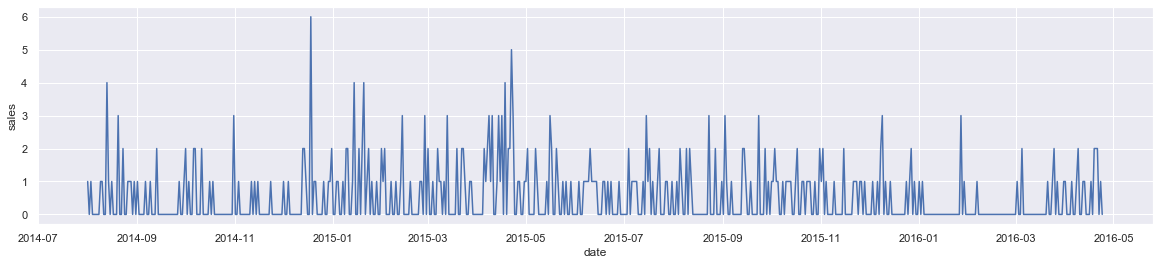

In [48]:
sns.set(rc={'figure.figsize':(20,4)})
sns.lineplot(x="date", y="sales", data=train_single_record)
plt.show()

In [59]:
nn = NeuralNetwork([31,2,1],'tanh')

In [71]:
train_single_record

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_7,lag_14,lag_21,lag_28,rmean_7_7,rmean_14_7,rmean_21_7,rmean_28_7,rmean_7_28,rmean_14_28,rmean_21_28,rmean_28_28,week,quarter,mday
21643516,FOODS_3_111_TX_1_validation,2335,6,4,2,1,1281,1.0,2014-08-01,11426,0,7,8,2014,0,0,0,0,1.0,1.0,0.0,4.980469,0.0,0.0,0.0,0.0,0.571289,0.285645,0.000000,0.000000,0.214233,0.071411,0.000000,0.392822,31,3,1
21844410,FOODS_3_111_TX_1_validation,2335,6,4,2,1,1282,0.0,2014-08-02,11427,2,1,8,2014,0,0,0,0,1.0,0.0,1.0,4.980469,0.0,0.0,0.0,0.0,0.571289,0.285645,0.000000,0.000000,0.214233,0.071411,0.000000,0.285645,31,3,2
21844411,FOODS_3_111_TX_1_validation,2335,6,4,2,1,1283,1.0,2014-08-03,11427,3,2,8,2014,0,0,0,0,1.0,1.0,1.0,4.980469,0.0,0.0,0.0,0.0,0.571289,0.285645,0.000000,0.000000,0.214233,0.071411,0.000000,0.214233,31,3,3
21844412,FOODS_3_111_TX_1_validation,2335,6,4,2,1,1284,0.0,2014-08-04,11427,1,3,8,2014,0,0,0,0,1.0,0.0,0.0,4.980469,0.0,1.0,0.0,0.0,0.428467,0.428467,0.000000,0.000000,0.214233,0.107117,0.000000,0.214233,32,3,4
21844413,FOODS_3_111_TX_1_validation,2335,6,4,2,1,1285,0.0,2014-08-05,11427,5,4,8,2014,0,0,0,0,1.0,1.0,1.0,4.980469,0.0,1.0,0.0,0.0,0.285645,0.571289,0.000000,0.000000,0.214233,0.142822,0.000000,0.214233,32,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40545530,FOODS_3_111_TX_1_validation,2335,6,4,2,1,1909,2.0,2016-04-20,11612,6,5,4,2016,0,0,0,0,0.0,0.0,0.0,4.980469,1.0,0.0,0.0,0.0,0.714355,0.428467,0.571289,0.142822,0.464355,0.285645,0.250000,0.142822,16,2,20
40545531,FOODS_3_111_TX_1_validation,2335,6,4,2,1,1910,2.0,2016-04-21,11612,4,6,4,2016,0,0,0,0,0.0,0.0,0.0,4.980469,0.0,0.0,1.0,1.0,0.714355,0.285645,0.571289,0.285645,0.464355,0.285645,0.285645,0.178589,16,2,21
40545532,FOODS_3_111_TX_1_validation,2335,6,4,2,1,1911,0.0,2016-04-22,11612,0,7,4,2016,0,0,0,0,0.0,0.0,0.0,4.980469,0.0,1.0,1.0,2.0,0.571289,0.285645,0.428467,0.571289,0.464355,0.321533,0.321533,0.250000,16,2,22
40686301,FOODS_3_111_TX_1_validation,2335,6,4,2,1,1912,1.0,2016-04-23,11613,2,1,4,2016,0,0,0,0,0.0,0.0,0.0,4.980469,0.0,2.0,0.0,0.0,0.285645,0.571289,0.428467,0.571289,0.464355,0.392822,0.250000,0.250000,16,2,23


In [62]:
nn.fit(train_single_record[train_cols],train_single_record['sales'])

In [70]:
nn.predict(train_single_record[train_cols].loc[40545531])

array([0.93370918])